In [8]:
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

symbol = 'AMZN'
start_date = '2004-01-01'
end_date = '2016-12-31'
df = data.get_data_yahoo(symbol, start_date, end_date)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-31,52.820000,53.480000,52.400002,52.619999,52.619999,5307200
2004-01-02,52.759998,53.130001,51.430000,51.900002,51.900002,6639900
2004-01-05,52.000000,53.599998,51.369999,53.270000,53.270000,11284100
2004-01-06,53.110001,53.500000,52.740002,53.029999,53.029999,5985500
2004-01-07,52.180000,52.660000,50.939999,51.900002,51.900002,9242700


In [9]:
#出于简化目的，这里只用收盘价
df = df['Close']

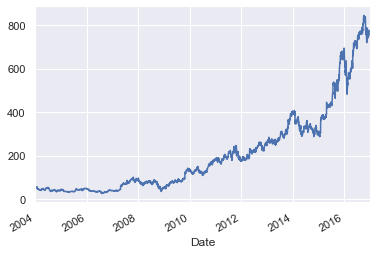

In [10]:
#使用plot()画出可视化图像
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn;

seaborn.set()
df.plot()

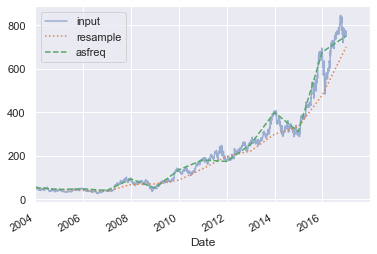

In [11]:
#用resample对数据进行重取样（可以理解为统计的粒度大小改变）。也可以使用asfreq()但二者有一定的区别
#案例采用向后取样（'BA'最后一个工作日），resample（）以数据累计为基础，返回的是上一年的均值；asfreq()以数据选择为基础，返回的是上一年最后一天的收盘价格
df.plot(alpha=0.5,style='-')
#resample重采样画图
df.resample('BA').mean().plot(style=':')
#asfreq()重采样画图
df.asfreq('BA').plot(style='--')
#整体图像图例设计
plt.legend(['input','resample','asfreq'],
          loc='upper left')

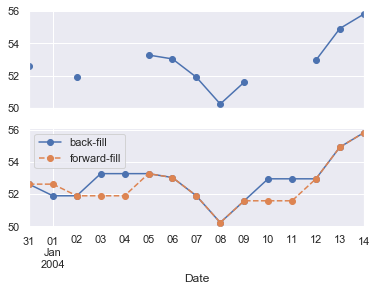

In [14]:
#asfreq的method参数可以设置向前、向后填充确实值的方法
#假如对天数进行重取样，使其包含周末
fig,ax = plt.subplots(2,sharex = True)  #包含两个子图，共用X轴
data = df.iloc[:10]#只画前10条数据
data.asfreq('D').plot(ax = ax[0],marker='o')#单纯重采样,画在第一个y轴上,非工作日的股价是缺失值，所以不会画在图上

data.asfreq('D',method='bfill').plot(ax=ax[1],style='-o')#向后填充
data.asfreq('D',method='ffill').plot(ax=ax[1],style='--o')#向前填充

ax[1].legend(['back-fill','forward-fill'])

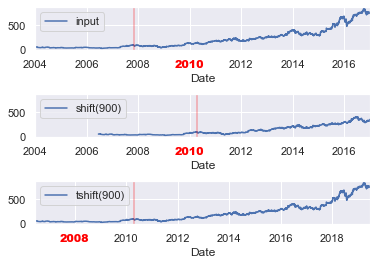

In [19]:
#时间序列中，还有一种重要的操作是时间迁移。涉及shift()和tshift()两个函数。shift迁移数据，tshift迁移索引
#下用这两个方法让数据迁移900天
fig,ax = plt.subplots(3,sharey=True)
#调整子图，避免叠在一起
plt.subplots_adjust(wspace=0.5,hspace=1)

#向后填充重取样
df = df.asfreq('D',method='pad')

df.plot(ax=ax[0])
df.shift(900).plot(ax=ax[1])
df.tshift(900).plot(ax=ax[2])

#给每个图设置图例和标签
import pandas as pd
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900,'D')

ax[0].legend(['input'],loc=2)
ax[0].get_xticklabels()[4].set(weight='heavy',color='red')
ax[0].axvline(local_max,alpha=0.3,color='red')

ax[1].legend(['shift(900)'],loc=2)
ax[1].get_xticklabels()[4].set(weight='heavy',color='red')
ax[1].axvline(local_max+offset,alpha=0.3,color='red')
#shift将数据向前（相当于时间往后）推了900天，所以前面一段数据空白，缺少数据

ax[2].legend(['tshift(900)'],loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy',color='red')
ax[2].axvline(local_max+offset,alpha=0.3,color='red')
#tshift将时间索引往后推了900天，所以时间坐标不一样

Text(0, 0.5, '% Return on Investment')

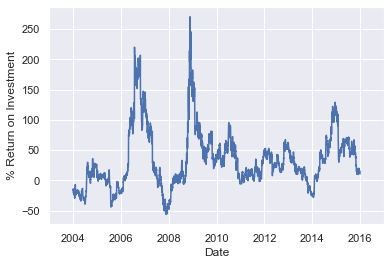

In [20]:
#时间迁移最主要的应用场景在于计算不同时段的差异。可以用迁移后的值来计算一年期的投资回报率ROI
ROI = 100 * (df.tshift(-365)/df -1)
ROI.plot()
plt.ylabel('% Return on Investment')

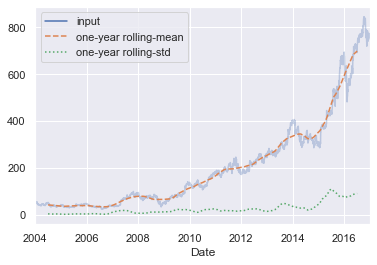

In [22]:
#时间序列的第三种需要是进行移动时间窗口。移动视图（rolling view）可以比较方便的实现不同时间窗口内的数值累计统计
rolling = df.rolling(365,center=True)#以365天为一个时间窗口

data = pd.DataFrame({'input':df,
                    'one-year rolling-mean':rolling.mean(),
                    'one-year rolling-std':rolling.std()})   #也可以用aggregate(),apply()来自定义方法
ax = data.plot(style=['-','--',':'])
ax.lines[0].set_alpha(0.3)